In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../../lab_1/')

from functions import (
    get_portfolio_expected_return,
    get_portfolio_std,
    generate_short_ratios,
)

from typing import List
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.simplefilter(action='ignore', category=RuntimeWarning)

PATH_TO_DATA = "../../lab_1/data/data_with_return.csv"

In [212]:
df = pd.read_csv(PATH_TO_DATA, encoding='UTF-16')
df.head(1)

,TRADEDATE,SECID,NUMTRADES,LEGALCLOSEPRICE,CLOSE,VOLUME,TRENDCLSPR,RETURN
0,2018-01-03,AFKS,5071,12.35,12.35,20687500,2.15,0.0


Выберем 50 акций, которые имеют наибольший объем, а значи они имеют наибольшую ликвидность. Предпологается, что такие реакции будут интереснее для наблюдений.

In [3]:
stocks_50 = df.groupby(by=["SECID"], as_index=False)\
    .agg({"VOLUME": "median"})\
    .sort_values(by="VOLUME", ascending=False)\
    .head(50).SECID

df = df[df.SECID.isin(stocks_50)]

In [209]:
NUM_RANDOM_PORTFOLIO = 100
SEED = 18
np.random.seed(SEED)
N = df.SECID.nunique()

weights = []
random_portfolio_dict = {"mean": [], "std": [], "type": []}
for _ in range(NUM_RANDOM_PORTFOLIO):
    ratios = np.random.dirichlet(np.ones(N)).tolist()
    weight = pd.DataFrame({"weights":ratios}, index=list(df.SECID.unique()))
    ex_return = get_portfolio_expected_return(df, weight.to_dict()["weights"])
    ex_std = get_portfolio_std(df, ratios)
    random_portfolio_dict["mean"].append(ex_return)
    random_portfolio_dict["std"].append(ex_std)
    random_portfolio_dict["type"].append("not_short_sales")
    weights.append(weight)

weights_short = []
for _ in range(NUM_RANDOM_PORTFOLIO):
    ratios = generate_short_ratios(N)
    weight = pd.DataFrame({"weights":ratios}, index=list(df.SECID.unique()))
    ex_return = get_portfolio_expected_return(df, weight.to_dict()["weights"])
    ex_std = get_portfolio_std(df, ratios)
    random_portfolio_dict["mean"].append(ex_return)
    random_portfolio_dict["std"].append(ex_std)
    random_portfolio_dict["type"].append("with_short_sales")
    weights_short.append(weight)

In [210]:
random_portfolio_df = pd.DataFrame(random_portfolio_dict)

equal_ratios = [1/N]*N
equal_expected_return = get_portfolio_expected_return(df, equal_ratios)
equal_std = get_portfolio_std(df, equal_ratios)
min_portfolio = random_portfolio_df[random_portfolio_df.type == "not_short_sales"].sort_values(by="std").head(1)

equal_portfolio = pd.DataFrame({"mean": [equal_expected_return], "std": [equal_std], "type": ["equal_portfolio"]})
index_portfolio = pd.DataFrame({"mean": [0.000377], "std": [0.010814], "type": ["index_portfolio"]})
min_portfolio = pd.DataFrame({"mean": min_portfolio["mean"], "std": min_portfolio["std"], "type": ["min_portfolio"]})

min_portfolio_short = random_portfolio_df[random_portfolio_df.type == "with_short_sales"].sort_values(by="std").head(1)
min_portfolio_short = pd.DataFrame({"mean": min_portfolio_short["mean"], "std": min_portfolio_short["std"], "type": ["min_portfolio_short"]})

portfolio_df = pd.concat([random_portfolio_df, equal_portfolio, index_portfolio, min_portfolio, min_portfolio_short])

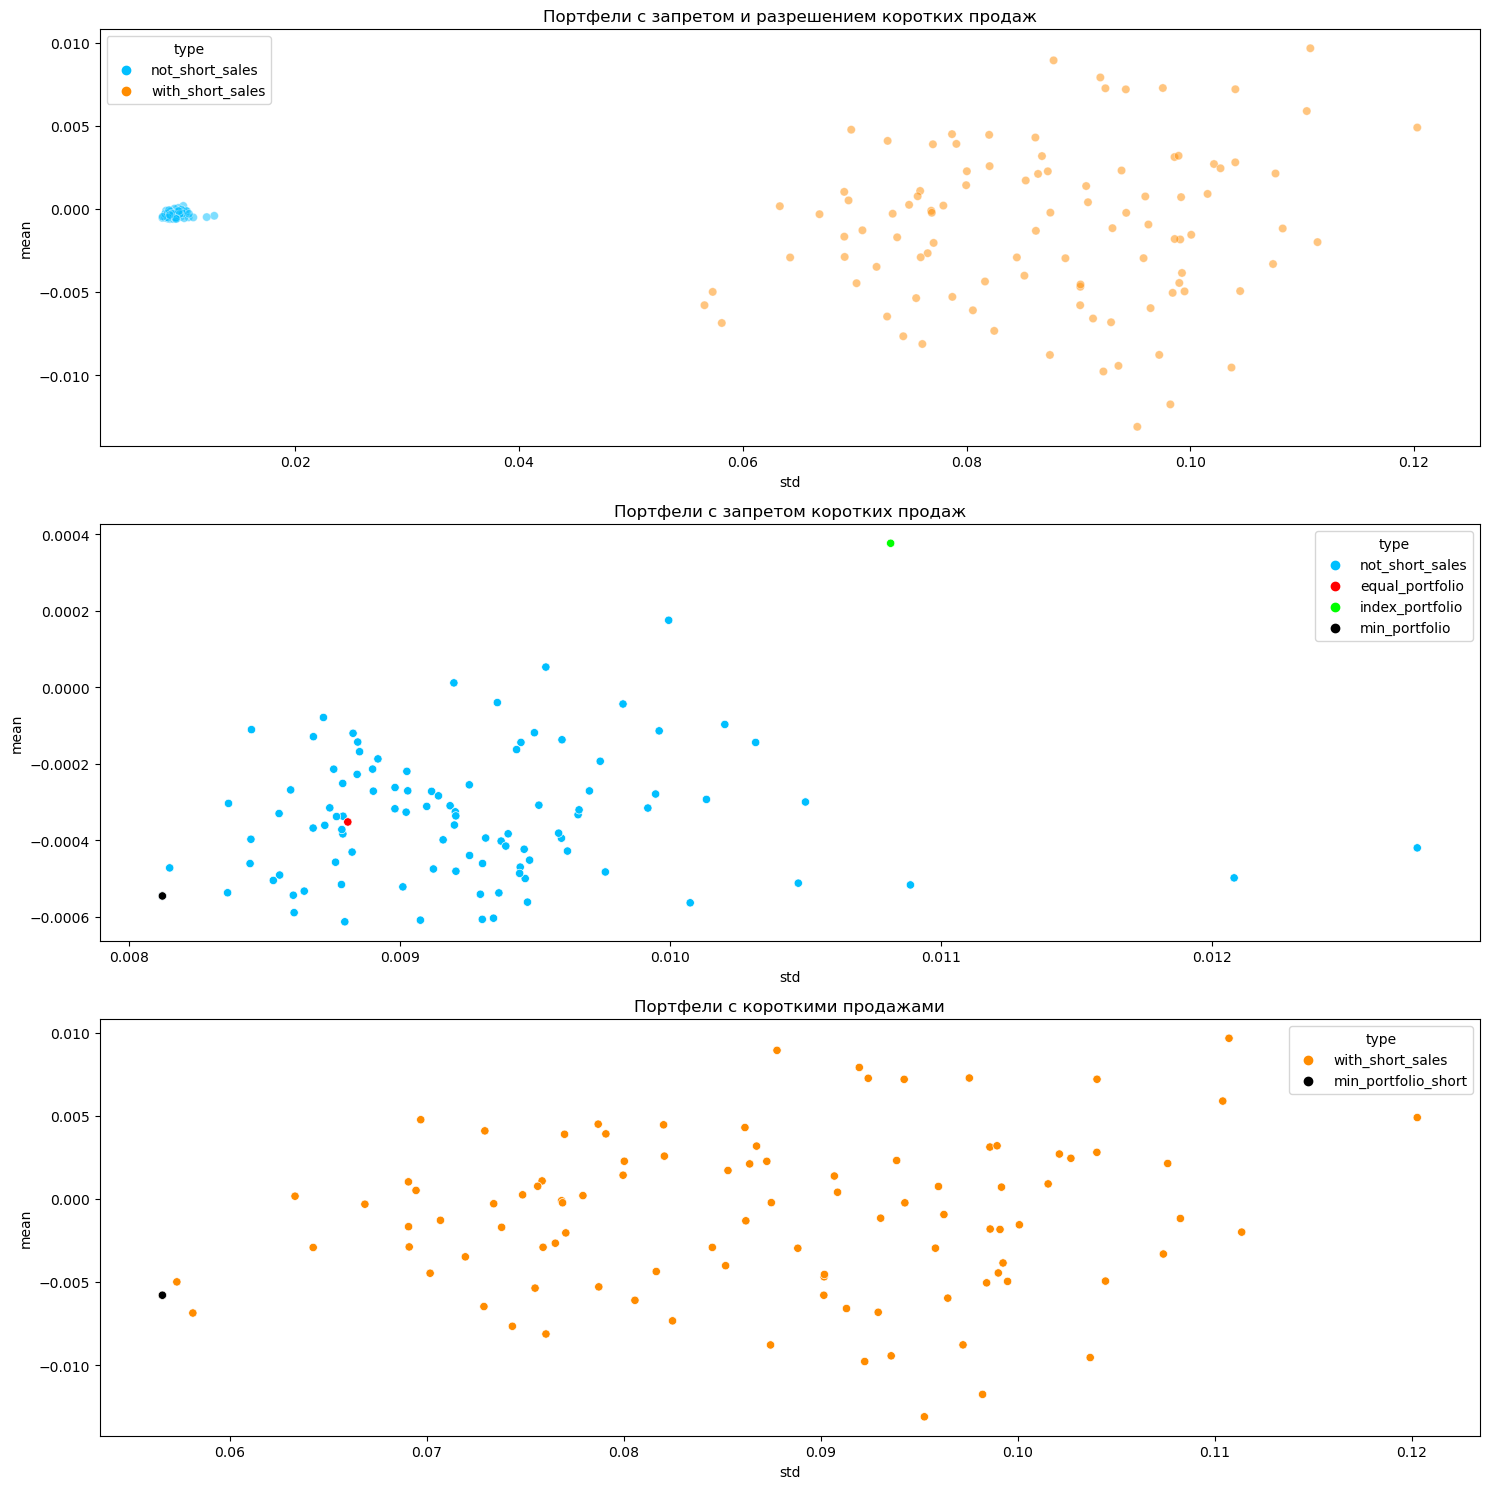

In [211]:
def get_df_by_type(df: pd.DataFrame, types_name: List):
    return df[df.type.isin(types_name)]

custom_palette = {
    "with_short_sales": "#FF8C00",
    "not_short_sales": "#00BFFF",
    "equal_portfolio": "#FF0000",
    "index_portfolio": "#00FF00",
    "min_portfolio": "#000000",
    "min_portfolio_short": "#000000",
}

fig, ax = plt.subplots(3, 1, figsize=(15, 15))
types_name = ["not_short_sales", "with_short_sales"]
sns.scatterplot(data=get_df_by_type(portfolio_df, types_name), x="std", y="mean", hue="type", alpha=0.5, palette=custom_palette, ax=ax[0]);
ax[0].set_title("Портфели с запретом и разрешением коротких продаж")

types_name = ["not_short_sales", "equal_portfolio", "index_portfolio", "min_portfolio"]
sns.scatterplot(data=get_df_by_type(portfolio_df, types_name), x="std", y="mean", hue="type", palette=custom_palette, ax=ax[1]);
ax[1].set_title("Портфели с запретом коротких продаж")

types_name = ["with_short_sales", "min_portfolio_short"]
sns.scatterplot(data=get_df_by_type(portfolio_df, types_name), x="std", y="mean", hue="type", palette=custom_palette, ax=ax[2]);
ax[2].set_title("Портфели с короткими продажами");

fig.tight_layout()